# Transportation Analysis Notebook 

**Contributors:** Micah Yong, Annie Lin, Bongi Fleischer, Daniel Yamada

In [1]:
# Import statements
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import arviz as avz

# Modeling 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import pymc3 as pm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.metrics import RootMeanSquaredError
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Flatten

# Hyperparameter tuning (commenting out for deliverable)
# import wandb
# from wandb.keras import WandbCallback

# Package settings
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
pd.options.mode.chained_assignment = None
random_state = 42
import warnings
warnings.filterwarnings('ignore')

2022-05-09 19:53:40.407501: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-09 19:53:40.407537: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Research Question 1: How well do transit ridership and infrastructure spending in the transportation sector predict GDP?

## 2.3: EDA

In this part, we will clean the monthly transportation statistics dataset. 
- We will normalize each column using [min-max normalization](https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization)). We decided against other normalization techniques, such as [z-score normalization](https://en.wikipedia.org/wiki/Standard_score), because each input variable does not necessarily follow a normal distribution. 

Then, we will make initial observations about the data by building scatter plots for each feature against Real GDP and computing the corresponding correlation coefficient. 

In [2]:
# Load in original dataframe 
data = pd.read_csv("Monthly_Transportation_Statistics.csv")

# We want to keep track of time 
metadata_columns = ["Date", "Index"]

# We want to compute GDP. We'll keep around employment statistics as sanity checks
output_columns = ["Real Gross Domestic Product - Seasonally Adjusted"]

# We will utilize measures of transportation ridership + transportation spending 
ridership_columns = [
    "Transit Ridership - Other Transit Modes - Adjusted",
    "Transit Ridership - Fixed Route Bus - Adjusted",
    "Transit Ridership - Urban Rail - Adjusted",
    "Passenger Rail Passengers",
    "Transportation Services Index - Passenger",
]

spending_columns = [
    "State and Local Government Construction Spending - Transportation",
    "State and Local Government Construction Spending - Mass Transit",
    "State and Local Government Construction Spending - Automotive",
]

prediction_columns = ridership_columns + spending_columns
all_columns = output_columns + prediction_columns 
original_df = data[all_columns]
df = data[all_columns]

# Create effective spending columns => average spending per month from the past 4 years
df = df.dropna(subset=spending_columns)
average_spending_columns = []

for spending_feature in spending_columns:
    average_five_year_spending = spending_feature + " (Mean)"
    average_spending_columns.append(average_five_year_spending)
    df[average_five_year_spending] = df[spending_feature].rolling(4 * 12, closed="left").mean()

df = df.dropna(subset=average_spending_columns)
df = df.drop(spending_columns, axis=1)
prediction_columns = ridership_columns + average_spending_columns

# Drop null values
y_val = "Real Gross Domestic Product - Seasonally Adjusted"
all_columns = output_columns + prediction_columns # + extra_output_columns
df = df.dropna(subset=all_columns)

# Normalize columns to a common scale (min-max scaling)
df = (df - df.min()) / (df.max() - df.min())

State and Local Government Construction Spending - Mass Transit (Mean) : 0.9602731314414302
State and Local Government Construction Spending - Transportation (Mean) : 0.9484700572419957
State and Local Government Construction Spending - Automotive (Mean) : -0.7325552534695297
Transit Ridership - Fixed Route Bus - Adjusted : -0.5360949656480716
Transit Ridership - Other Transit Modes - Adjusted : 0.303578228536764
Transportation Services Index - Passenger : 0.07719010295170332
Passenger Rail Passengers : 0.0450442644665541
Transit Ridership - Urban Rail - Adjusted : 0.043868566476107484


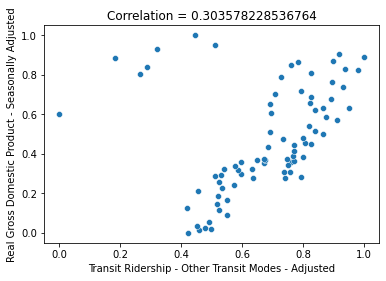

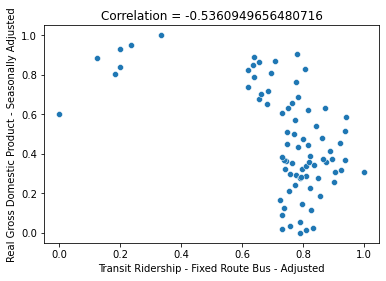

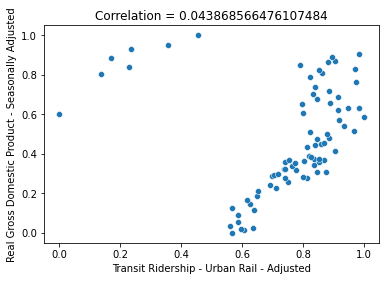

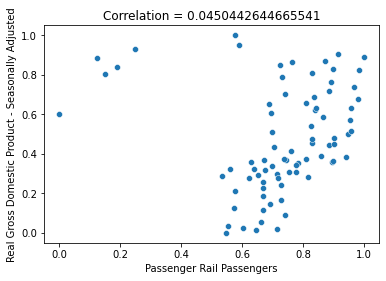

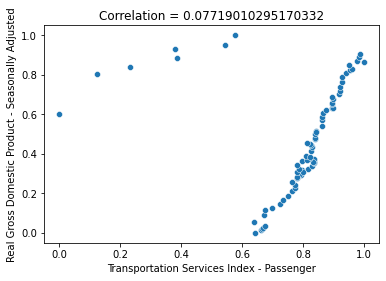

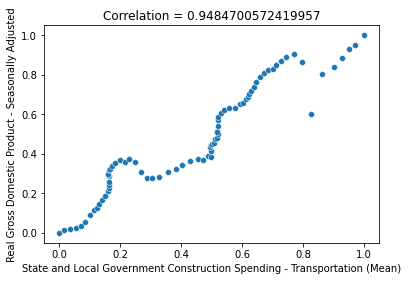

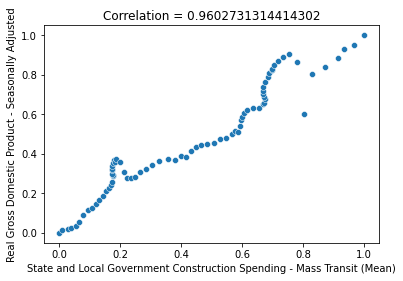

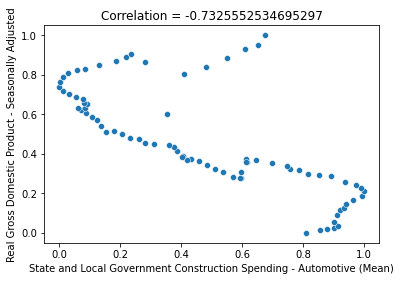

In [3]:
# Computing an estimate of correlation coefficient
def correlation_coefficient_estimate(x, y):
    """Returns the Pearson Correlation Coefficient Estimate amongst non-nan entries across x and y."""
    f = df[[x, y]]
    f = f.dropna()

    return sp.stats.pearsonr(f[x], f[y])[0]

# Plotting and tracking correlation estimates
correlations = []

for i, feature in enumerate(prediction_columns): 
    plt.figure(i)
    r = correlation_coefficient_estimate(feature, y_val)
    correlations.append((r, feature))
    sns.scatterplot(x=df[feature], y=df[y_val]).set(title="Correlation = " + str(r))
    
# Sort and output correlations from most correlated to least
correlations.sort(reverse=True, key=lambda x: abs(x[0]))
for r, feature in correlations:
    print(feature + " : " + str(r))

In [4]:
# Rename dataframe columns (statsmodels and pymc3 doesn't allow attribute names with spaces)
rename_dict = {y_val: 'y'}
renamed_features = []
for i, col in enumerate(prediction_columns): 
    feat = "x" + str(i)
    rename_dict[col] = feat
    renamed_features.append(feat)
renamed_df = df.rename(columns=rename_dict)

# 2.6: Prediction with GLMs and nonparametric models

In [5]:
# If using WandB for Hyperparameter tuning, use this block
# wandb.init(project="transport", entity="micahtyong")
# config = wandb.config
# config.test_size = 0.3
# wandb.config.update(config)

# Otherwise, use this block for the reproducible deliverable
config = {}
config['test_size'] = 0.3

## Frequentist Implementation of a Linear GLM using statsmodels

In the next few code blocks, we will be creating a Linear GLM manually via `statsmodels`. Before that, we will mitigate multicollinearity by removing features with a [variance inflation factor (VIF)](https://www.statisticshowto.com/variance-inflation-factor/) greater than $6$. 
- According to [this data science article](https://quantifyinghealth.com/vif-threshold/), the typical VIF threshold for research papers is $!0$. However, since we are working with a smaller dataset, we opted for a more conservative threshold. 

See Appendex A.2 for a similar analysis using principal component analysis. 

In [6]:
# Computing the VIF of each feature, then dropping columns with a VIF > threshold
def calculate_vif_(X, thresh=6.0, log=False):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            if log:
                print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    if log: 
        print('Remaining variables:')
        print(X.columns[variables])
    return X.iloc[:, variables]

prediction_columns_wo_colinearity = calculate_vif_(renamed_df[renamed_features], log=True)

dropping 'x2' at index: 2
dropping 'x0' at index: 0
dropping 'x6' at index: 4
dropping 'x4' at index: 2
dropping 'x3' at index: 1
Remaining variables:
Index(['x1', 'x5', 'x7'], dtype='object')


In [7]:
# Manually construct linear regression skeleton
train, test = train_test_split(renamed_df, test_size=config['test_size'])

# Compute formula with only the non-colinear variables; consider interaction variables
formula = f'y ~ ' + ' + '.join(prediction_columns_wo_colinearity)
print(formula)

# Construct model from formula 
glm_ = smf.glm(formula=formula,
              data=train,
              family=sm.families.Gaussian())
glm = glm_.fit()
glm.summary() # Passes pearson chi_squared test, but not log likelihood test

y ~ x1 + x5 + x7


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                   56
Model:                            GLM   Df Residuals:                       52
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                       0.0059934
Method:                          IRLS   Log-Likelihood:                 65.893
Date:                Mon, 09 May 2022   Deviance:                      0.31166
Time:                        19:53:43   Pearson chi2:                    0.312
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1094      0.144      0.758      0.449      -0.174       0.393
x1            -0.0083      0.110     -0.075      0.940      -0.223       0.207
x5             0.9233      0.101      9.166      0.000       0.726       1.121
x7            -0.0687      0.060     -1.141      0.254      -0.187       0.049
==============================================================================
"""

In [8]:
# Extracting RMSE
y_true = np.array(test['y'])
y_hat = glm.predict(test)
rmse_freq = sm.tools.eval_measures.rmse(y_true, y_hat)
rmse_freq

0.09645930287120114

To quantify the uncertainty of our model results, we will use bootstrap. 

In [9]:
# Bootstrapping the RMSE
values = df.values
n_iterations = 500
n_size = int(len(data) * 0.50) 

stats = []
for i in range(n_iterations):
    # Data splitting 
    renamed_df_iter = renamed_df.sample(frac=1, replace=True, random_state=random_state)
    train, test = train_test_split(renamed_df_iter, test_size=config['test_size'])
    
    # Mitigate multicollinearity w/ VIF
    prediction_columns_wo_colinearity_iter = calculate_vif_(renamed_df_iter[renamed_features])
    formula_iter = f'y ~ ' + ' + '.join(prediction_columns_wo_colinearity_iter)

    # Construct model from formula 
    glm_ = smf.glm(formula=formula_iter,
                  data=train,
                  family=sm.families.Gaussian())
    glm = glm_.fit()
    
    # Extract RMSE
    y_true = np.array(test['y'])
    y_hat = glm.predict(test)
    rmse_freq = sm.tools.eval_measures.rmse(y_true, y_hat)
    stats.append(rmse_freq)

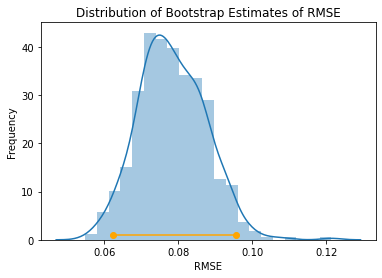

In [10]:
# Plotting the range of MAE
plt.ylabel("Frequency")
plt.xlabel("RMSE")
plt.title("Distribution of Bootstrap Estimates of RMSE")
sns.distplot(stats)

# Construct 95% confidence interval
lower = np.percentile(stats, 2.5)
upper = np.percentile(stats, 97.5)
plt.plot((lower,upper),(1, 1),'ro-',color='orange')

In [11]:
# Interpreting Results
range_y = original_df[y_val].max() - original_df[y_val].min()
lower_val = lower * range_y
upper_val = upper * range_y
lower_val, upper_val 

(1108154577362.7148, 1701143792947.626)

### Bayesian implementation using Pymc3

In [12]:
# We can reuse the formula derived in the frequentist approach to construct a Bayesian GLM
print(formula)

bglm = pm.Model()

with bglm as gaussian_model:
    # Normally distributed priors
    family = pm.glm.families.Normal()
    # create the model 
    pm.GLM.from_formula(formula,data=renamed_df,family=family)
    # sample
    gaussian_trace = pm.sample(1000,return_inferencedata=True)
    
summary = avz.summary(gaussian_trace) 
print(summary)

y ~ x1 + x5 + x7


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x7, x5, x1, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8970758202739325, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8900388816567751, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept -0.021  0.131  -0.286    0.211      0.006    0.005     480.0   
x1         0.111  0.093  -0.063    0.287      0.004    0.003     539.0   
x5         0.979  0.098   0.778    1.152      0.004    0.003     500.0   
x7        -0.039  0.060  -0.155    0.071      0.003    0.002     568.0   
sd         0.084  0.007   0.072    0.096      0.000    0.000     847.0   

           ess_tail  r_hat  
Intercept     421.0   1.02  
x1            409.0   1.02  
x5            449.0   1.02  
x7            445.0   1.02  
sd            662.0   1.00  


In [13]:
# Draw posterior predictive samples from linear model 
chosen_features = list(prediction_columns_wo_colinearity.columns) 
with gaussian_model:
    gaussian_ppc = pm.sample_posterior_predictive(
        gaussian_trace, var_names = chosen_features + ['y'] + ['Intercept']
    )

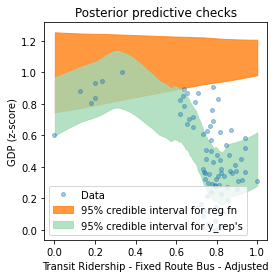

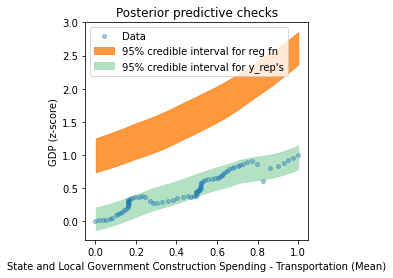

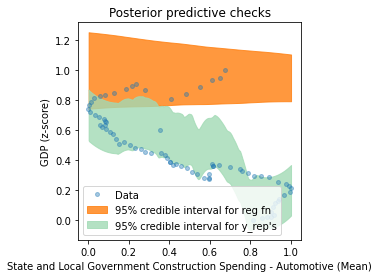

In [14]:
# Perform posterior predictive checking across all features
name_dict = {v: k for k, v in rename_dict.items()}
for col in chosen_features:
    # Compute the posterior regression function (y hat values) for the linear GLM
    y_hat_gaussian = np.exp(
        np.outer(gaussian_ppc[col], prediction_columns_wo_colinearity[col])
        + gaussian_ppc["Intercept"][:,np.newaxis]
    )
    
    # Plot posterior predictive checks, construct credible interval 
    _, ax = plt.subplots(figsize = (4,4))

    ax.plot(prediction_columns_wo_colinearity[col], df[y_val], "o", ms=4, alpha=0.4, label="Data")
    avz.plot_hdi(
        prediction_columns_wo_colinearity[col],
        y_hat_gaussian,
        ax=ax,
        hdi_prob=0.95,
        fill_kwargs={"alpha": 0.8, "label": "95% credible interval for reg fn"},
    )
    avz.plot_hdi(
        prediction_columns_wo_colinearity[col],
        gaussian_ppc["y"],
        ax=ax,
        hdi_prob=0.95,
        fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "95% credible interval for y_rep's"},
    )

    ax.set_xlabel(f"{name_dict[col]}")
    ax.set_ylabel("GDP (z-score)")
    ax.set_title("Posterior predictive checks")
    ax.legend(fontsize=10);

### Part 3: Building a neural network to predict GDP 

In [15]:
# Prepare Data (rely on neural network to perform dimensionality reduction)
df_nn = renamed_df
dataset = df_nn.values
X = dataset[:, 1:] # columns after 1st col are the input features 
Y = dataset[:,0:1] # 1st col (real GDP) is feature we want to predict 

# Split data into train, test, and validation 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=config['test_size'])

In [16]:
# Use this code block to tune hyperparameters using WandB
# wandb.init(project="transport", entity="micahtyong")
# config = wandb.config
# config.num_hidden_layers = 5
# config.input_units = 256
# config.hidden_units = 256
# config.epochs = 400
# config.batch_size = 32
# wandb.config.update(config)

# Use this code block for the reproducible deliverable
config['num_hidden_layers'] = 4
config['input_units'] = 256
config['hidden_units'] = 256
config['epochs'] = 700
config['batch_size'] = 16

In [17]:
# Set up model hyperparameters
NN_model = Sequential()

# The Input Layer : Takes in k features with a relu (nonlinear) activation function
NN_model.add(Dense(config['input_units'], kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers : To model interaction variables and more 
for i in range(config['num_hidden_layers']):
    NN_model.add(Dense(config['hidden_units'], kernel_initializer='normal',activation='relu'))

# The Output Layer : Return an estimate for real GDP
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Create RMSE loss function
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Compile the network 
NN_model.compile(optimizer='adam',
    loss=root_mean_squared_error,
    metrics=[RootMeanSquaredError(), 'mean_absolute_error'])
NN_model.summary()

2022-05-09 19:54:47.872514: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-09 19:54:47.872554: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-09 19:54:47.872580: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-micahtyong): /proc/driver/nvidia/version does not exist
2022-05-09 19:54:47.872987: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               2304      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 265,729
Trainable params: 265,729
Non-trainable params: 0
__________________________________________________

In [18]:
# Fit model to training data (segmenting a portion for validation)
NN_model.fit(X_train, Y_train, epochs=config['hidden_units'], batch_size=config['batch_size'],
             validation_split = 0.2, 
#              callbacks=[WandbCallback()]
            )

Epoch 1/256


2022-05-09 19:54:48.525370: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


3/3 [==============================] - 1s 118ms/step - loss: 0.5194 - root_mean_squared_error: 0.5204 - mean_absolute_error: 0.4441 - val_loss: 0.3987 - val_root_mean_squared_error: 0.3987 - val_mean_absolute_error: 0.3232
Epoch 2/256
3/3 [==============================] - 0s 16ms/step - loss: 0.3275 - root_mean_squared_error: 0.3516 - mean_absolute_error: 0.2789 - val_loss: 0.2895 - val_root_mean_squared_error: 0.2895 - val_mean_absolute_error: 0.2595
Epoch 3/256
3/3 [==============================] - 0s 16ms/step - loss: 0.3020 - root_mean_squared_error: 0.3025 - mean_absolute_error: 0.2696 - val_loss: 0.2052 - val_root_mean_squared_error: 0.2052 - val_mean_absolute_error: 0.1747
Epoch 4/256
3/3 [==============================] - 0s 18ms/step - loss: 0.1858 - root_mean_squared_error: 0.1884 - mean_absolute_error: 0.1557 - val_loss: 0.1924 - val_root_mean_squared_error: 0.1924 - val_mean_absolute_error: 0.1423
Epoch 5/256
3/3 [==============================] - 0s 17ms/step - loss: 0.1

In [19]:
# Interpreting results
loss, rmse, err = NN_model.evaluate(X_test, Y_test)
# wandb.finish()
print(rmse * range_y)

1/1 [==============================] - 0s 21ms/step - loss: 0.0214 - root_mean_squared_error: 0.0214 - mean_absolute_error: 0.0160
381181213347.4946


# Appendix

## A.1 Frequentist Implementation of Linear Model using Sklearn

In this code block, we attempt to bootstrap a simple regression model using `sklearn`. We decided against `sklearn`, since it didn't allow for us to adjust the priors of our input parameters. Furthermore, the package lacked out-of-the-box measures for goodness-of-fit, such as the log-likelihood test and Pearson chi-squared test. 

Text(0.5, 1.0, 'Distribution of Bootstrap Estimates of RMSE')

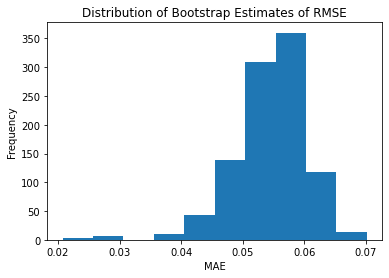

In [20]:
# Bootstrapping the MAE for a frequentist linear regression model 
values = df.values
n_iterations = 1000
n_size = int(len(data) * 0.50) 

# run bootstrap
stats = []
for i in range(n_iterations):
    # Train, test, validation split into 60% train, 20% test, 20% split
    train, validate, test = np.split(df.sample(frac=1, replace=True), 
                       [int(.6*len(df)), int(.8*len(df))])
    
    # Linear regression
    X = train[prediction_columns].to_numpy()
    Y = train[y_val].to_numpy()

    linear_regressor = LinearRegression(positive=True)  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    
    # Fit model and evaluate MAE 
    Y_pred = linear_regressor.predict(X)  # make predictions
    stats.append(np.sqrt(metrics.mean_squared_error(Y, Y_pred)))
    
# Plotting the range of MAE
plt.hist(stats)
plt.ylabel("Frequency")
plt.xlabel("MAE")
plt.title("Distribution of Bootstrap Estimates of RMSE")

## A.2 Eliminating Collinearity via Principal Component Analysis

In the next two code blocks, we attempt to build a simple linear regression model using `statsmodels`, and eliminate collinearity amongst input variables using Principal Component Analysis. We decided against PCA, since we lose the ability to attribute each "principal axis" to a singular input feature. In particular, when performing posterior predictive checking for our Bayesian model, we're unable to derive credible intervals for individual features––we can only interpret credible intervals for each principal axis. 

From the frequentist point of view, PCA yielded an RMSE of $\approx 0.064$, whereas the implementation using VIF yielded an RMSE of $\approx 0.08$. For the purposes of our research question, we're optimizing for interpretability over a slight improvement in performance. 

In [21]:
# PCA
train, test = train_test_split(renamed_df, test_size=config['test_size'])
n_components = 4
pca = PCA(n_components)
pca.fit(train[renamed_features])
pca_train_df = pd.DataFrame(pca.transform(train[renamed_features]), 
                      columns=['PCA%i' % i for i in range(n_components)], index=train.index)

# Part 1: Frequentist Implementation w/ PCA

# Compute formula with only the non-colinear variables; consider interaction variables
formula = f'y ~ ' + ' + '.join(list(pca_train_df.columns))
print(formula)
pca_train_df['y'] = train['y']
glm_ = smf.glm(formula=formula,
              data=pca_train_df,
              family=sm.families.Gaussian())

glm = glm_.fit()
print(glm.summary()) # Passes pearson chi_squared test, but not log likelihood test

# Extracting RMSE
pca_test_df = pd.DataFrame(pca.transform(test[renamed_features]), 
                      columns=['PCA%i' % i for i in range(n_components)], index=test.index)
y_true = np.array(test['y'])
y_hat = glm.predict(pca_test_df)
rmse_freq = sm.tools.eval_measures.rmse(y_true, y_hat)
rmse_freq

y ~ PCA0 + PCA1 + PCA2 + PCA3
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                   56
Model:                            GLM   Df Residuals:                       51
Model Family:                Gaussian   Df Model:                            4
Link Function:               identity   Scale:                       0.0031705
Method:                          IRLS   Log-Likelihood:                 84.266
Date:                Mon, 09 May 2022   Deviance:                      0.16170
Time:                        19:55:01   Pearson chi2:                    0.162
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4593 

0.06786628841628374

y ~ PCA0 + PCA1 + PCA2 + PCA3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, PCA3, PCA2, PCA1, PCA0, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  0.464  0.007   0.451    0.477      0.000    0.000    5069.0   
PCA0      -0.508  0.014  -0.535   -0.483      0.000    0.000    5843.0   
PCA1       0.215  0.017   0.185    0.247      0.000    0.000    5166.0   
PCA2      -0.482  0.058  -0.590   -0.376      0.001    0.001    5289.0   
PCA3       0.502  0.090   0.326    0.671      0.001    0.001    5539.0   
sd         0.060  0.005   0.051    0.071      0.000    0.000    5691.0   

           ess_tail  r_hat  
Intercept    3252.0    1.0  
PCA0         2982.0    1.0  
PCA1         2959.0    1.0  
PCA2         3369.0    1.0  
PCA3         3150.0    1.0  
sd           3042.0    1.0  


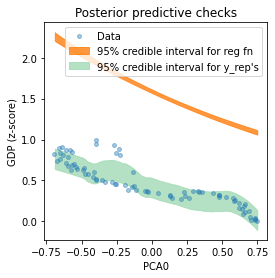

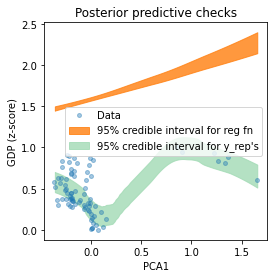

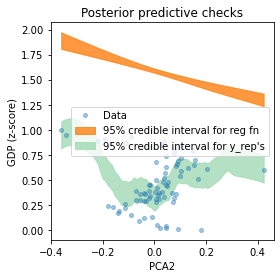

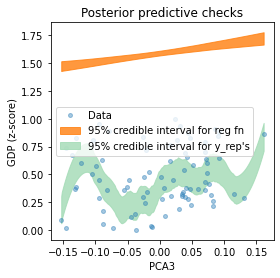

In [22]:
# Part 2: Bayesian Implementation w/ PCA
# We can reuse the formula derived in the frequentist approach to construct a Bayesian GLM
print(formula)

bglm = pm.Model()

pca_full_df = pd.DataFrame(pca.transform(renamed_df[renamed_features]), 
                      columns=['PCA%i' % i for i in range(n_components)], index=renamed_df.index)
pca_full_df['y'] = renamed_df['y']

with bglm as gaussian_model:
    # Normally distributed priors
    family = pm.glm.families.Normal()
    # create the model 
    pm.GLM.from_formula(formula,data=pca_full_df,family=family)
    # sample
    gaussian_trace = pm.sample(1000,return_inferencedata=True)
    
summary = avz.summary(gaussian_trace) 
print(summary)

# Draw posterior predictive samples from linear model 
with gaussian_model:
    gaussian_ppc = pm.sample_posterior_predictive(
        gaussian_trace, var_names=['PCA%i' % i for i in range(n_components)] + ['y'] + ['Intercept']
    )
    
# Perform posterior predictive checking across all features
name_dict = {v: k for k, v in rename_dict.items()}
for col in ['PCA%i' % i for i in range(n_components)]:
    # Compute the posterior regression function (y hat values) for the linear GLM
    y_hat_gaussian = np.exp(
        np.outer(gaussian_ppc[col], pca_full_df[col])
        + gaussian_ppc["Intercept"][:,np.newaxis]
    )
    
    # Plot posterior predictive checks, construct credible interval 
    _, ax = plt.subplots(figsize = (4,4))

    ax.plot(pca_full_df[col], df[y_val], "o", ms=4, alpha=0.4, label="Data")
    avz.plot_hdi(
        pca_full_df[col],
        y_hat_gaussian,
        ax=ax,
        hdi_prob=0.95,
        fill_kwargs={"alpha": 0.8, "label": "95% credible interval for reg fn"},
    )
    avz.plot_hdi(
        pca_full_df[col],
        gaussian_ppc["y"],
        ax=ax,
        hdi_prob=0.95,
        fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "95% credible interval for y_rep's"},
    )

    ax.set_xlabel(f"{col}")
    ax.set_ylabel("GDP (z-score)")
    ax.set_title("Posterior predictive checks")
    ax.legend(fontsize=10);

## A.3 Bootstrapping Confidence Intervals for invididual features

In the next code block, we attempt to use bootstrap to manually construct confidence intervals and standard errors for each feature in our dataset. We decided against this technique, since `statsmodels` gave confidence intervals and standard errors for each parameters already during its sampling phase. 

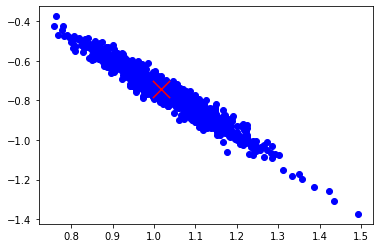

Bootstrap std error for const: 0.104
Bootstrap std error for variable: 0.132


In [23]:
import numpy.random as rnd
def bootstrap_xy(X, y, fnc, w=None, B=1000, plot=True):
    d = X.shape[1]
    N = X.shape[0]
    w_hat = fnc(X, y)
    w_boot = np.zeros(shape=(B,d))
    for b in range(B):
        bootstrap_indices = rnd.choice(np.arange(N), N)
        bootstrap_X = X.iloc[bootstrap_indices, :]
        bootstrap_y = y.iloc[bootstrap_indices]
        w_boot[b,:] = fnc(bootstrap_X, bootstrap_y)
    if plot:
        plt.scatter(w_boot[:,0], w_boot[:,1], c='b')
        plt.scatter(w_hat[0], w_hat[1], c='r', marker='x', s=300)
        if w:
            plt.scatter(w[0], w[1], c='g', marker='x', s=300)
        plt.show()
    return w_boot

def lin_model(x, y):
    model = sm.GLM(
        y, x,
        family=sm.families.Gaussian()
    )
    results = model.fit()
    params = results.params
    
    return params

w_gaussian_boot = bootstrap_xy(sm.add_constant(renamed_df.x1), renamed_df.y, lin_model)
beta_0, beta_1 = w_gaussian_boot.std(axis = 0)
print(f"Bootstrap std error for const: {beta_0:.3f}")
print(f"Bootstrap std error for variable: {beta_1:.3f}")